# Ejemplo 1: Conceptos básicos de análisis de datos espaciales en Python

Hola colegas, bienvenidas y bienvenidos al componente practico del curso. El proposito de este *notebook* (`*.ipynb`) es dar una idea general de las etapas del entrenamiento (y re-entrenamiento) de algoritmos de *Machine Learning*. Despues de revisar y *correr* este *notebook*, usted pondra:

1. Conocer librerias necesarias para el analisis de datos y entrenamiento de modelos de *Machine Learning*.
2. Cargar y visualizar datos raster y vectoriales.
3. Realizar reproyecciones y operaciones espaciales como *cropping*.
4. Usar datos vectoriales como anotaciones o *labels* para generar datos de entranamiento (y evaluacion).
5. Extraer informacion espectral a partir de las anotacione y construir `DataFrames`.
6. Generar diagramas y analisis estadisticos (basicos) con la informacion espectral.
7. Entrenar un algoritmo de *Machine Learning* y evaluar su capacidad predictiva en datos independendientes.
8. Generalizar o clasificar la imagen satelital (en un raster) de donde provienen las anotaciones.

## Cargar librerias

Las buenas practicas de programacion/desarrollo requieren que se hagan comentarios informativos en partes claves del *notebook* o segmento de desarrollo que respondan las siguientes preguntas sobre el codigo:

* Por que se requiere?
* Como funcionaria?
* Cual es su resultado esperado?

La siguiente seccion de codigo es bastante intuitiva y se hace mas obvia a medida que se tengan mas experiencia con los desarrollos. La idea es que se carguen las librerias, usando la funcion `import`, necesarias para realizar los analisis. En esta caso se destacan `shapely` para datos vectoriales y `rasterio` para rasters. Tambien, la libreria `sklearn` que permite entrenar modelos de *Machine Learning* y evaluar su rendimiento.

In [17]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as stats
from pandas.plotting import scatter_matrix
import shapely
import fiona
import geopandas as gpd
import rasterio
import rasterio.plot
import rasterio.mask
import rasterio.features
from rasterio.transform import from_origin, Affine
from pyproj import CRS
import rasterstats
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import ClassifierChain
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, recall_score, f1_score
import drive

ModuleNotFoundError: No module named 'drive'

In [8]:
!pip install rasterstats

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.8/144.8 kB 3.1 MB/s eta 0:00:00


In [10]:
!pip install rasterio

Cuando una libreria no esta instalada, obtenemos un mensaje de alerta como el siguiente:

In [11]:
#import SIMCITools

## Ingreso de datos

Una vez que se cuentan con las librerias necesarias para realizar los analisis, procedemos a cargar los datos.

* Raster: usamos la libreria `rasterio` y el metodo `open` para declarar la ruta (relativa) del raster:

In [23]:
!pip install google-api-python-client google-auth-httplib2 google-auth-oauthlib
from google.colab import drive # Import the drive module from google.colab

In [20]:
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
zona_estudio = rasterio.open("/content/drive/MyDrive/Laboral/RNZD/IA/Copia de Raster_Stack_Raw.tif")
zona_estudio.crs

CRS.from_wkt('PROJCS["WGS 84 / UTM zone 21S",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-57],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32721"]]')

El analisis de datos espaciales en Python requiere de verificar que el sistema coordenado de la informacion sea el apropiado para los analisis. En este ejercicio haremos procesos de interseccion espacial, por tanto, se requiera que toda la informacion tenga el mismo sistema coordenado (origen) definido por el metodo `.crs`.

Tambien podemos evaluar la forma o estructura de la informacion de `zona_estudio` con el metodo `.shape`:

In [24]:
zona_estudio.shape

(10888, 8014)

Esta informacion indica que `zona_estudio` es un raster de 10888 por 8014 pixeles, para un total de 87'256.432 pixeles.

Para cargar la informacion vectorial usamos la libreria `GeoPandas` con su alias `gpd` y su metodo `.read_file`:

In [26]:
lineas = gpd.read_file("/content/drive/MyDrive/Laboral/RNZD/IA/Copia de AnnotationLineDataSet.shp")
lineas.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

La información vectorial tiene un `CRS` diferente al `zona_estudio`, entonces debemos realizar una **reproyección** para que las operaciones espaciales tengan sentido.

In [27]:
lineas = lineas.to_crs(zona_estudio.crs)
lineas.crs

<Projected CRS: EPSG:32721>
Name: WGS 84 / UTM zone 21S
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 21S
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Perfecto, ahora sí podemos proceder con las operaciones espaciales. Sin embargo, observemos primero los datos del `GeoDataFrame` `lineas`:

In [28]:
lineas.head()

id Cobertura                                           geometry
0   1      Road  LINESTRING (534349.885 8946584.234, 534413.755...
1   2     River  LINESTRING (528884.214 8960051.762, 530137.468...
2   3      Road  LINESTRING (516297.794 8947127.307, 516655.471...
3   4      Crop  LINESTRING (520340.099 8948150.542, 520657.037...
4   7     River  LINESTRING (501353.065 8976788.691, 501325.81 ...

`lineas` es básicamente una tabla que agrupa líneas en el espacio y asocia una *label* o categoria a cada una de estas. Ahora miremos qué categías están represetandadas en este `GeoDataFrame`:

In [29]:
lineas.Cobertura.unique()

array(['Road', 'River', 'Crop', 'Forest', 'Eutrophication'], dtype=object)

Podemos confirmar que la información de  `lineas` tiene intersección con `zona_estudio`:

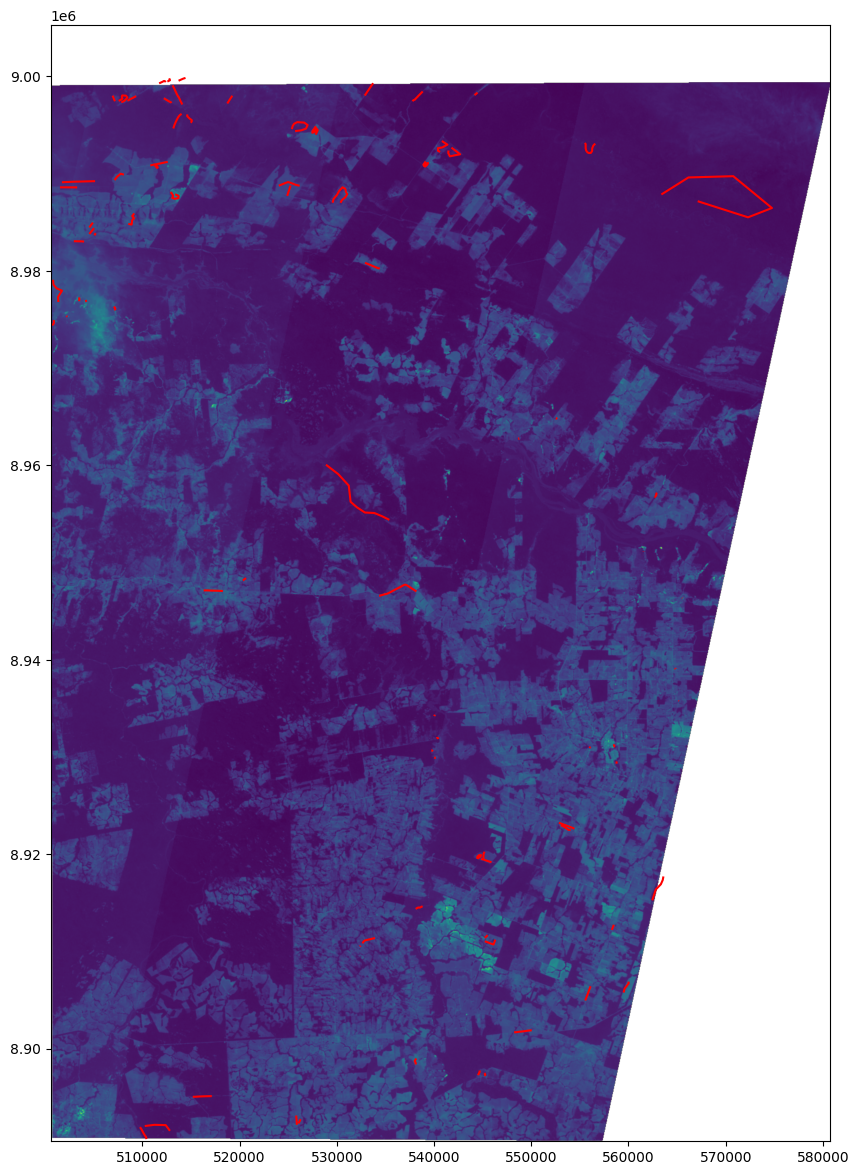

In [30]:
# Original
fig, ax = plt.subplots(figsize=(14.5, 14.5))
rasterio.plot.show(zona_estudio, ax=ax)
lineas.plot(ax=ax, color='red', edgecolor='black');

## Extraccion y preparación de datos de entrenamiento y evaluación

Como pudimos observar, `lineas` no cuenta con información espectral de `zona_estudio`, por esta razón debemos realizar un proceso de extracción de información, el cual puede ser realizado de diferentes formas:

* rasterizar `lineas` y extraer la información de los pixeles que presenten intersección.
* llevar a cabo la operación raster-vector de manera directa.

Por propósitos del ejercicio, vamos a ver paso a paso como se extrae esta información.

### Extraccion segun anotación con líneas

In [31]:
Out_Img_Crop, Out_Transform_Crop = rasterio.mask.mask(zona_estudio, lineas[lineas['Cobertura'] == 'Crop'].geometry, crop=True)
Out_Meta_Crop = zona_estudio.meta

Out_Img_Road, Out_Transform_Road = rasterio.mask.mask(zona_estudio, lineas[lineas['Cobertura'] == 'Road'].geometry, crop=True)
Out_Meta_Road = zona_estudio.meta

Out_Img_Forest, Out_Transform_Forest = rasterio.mask.mask(zona_estudio, lineas[lineas['Cobertura'] == 'Forest'].geometry, crop=True)
Out_Meta_Forest = zona_estudio.meta

Out_Img_River, Out_Transform_River = rasterio.mask.mask(zona_estudio, lineas[lineas['Cobertura'] == 'River'].geometry, crop=True)
Out_Meta_River = zona_estudio.meta

Out_Img_Eutrophication, Out_Transform_Eutrophication = rasterio.mask.mask(zona_estudio, lineas[lineas['Cobertura'] == 'Eutrophication'].geometry, crop=True)
Out_Meta_Eutrophication = zona_estudio.meta

In [32]:
zona_estudio.meta

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': 0.0,
 'width': 8014,
 'height': 10888,
 'count': 13,
 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 21S",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-57],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32721"]]'),
 'transform': Affine(10.0, 0.0, 500570.0,
        0.0, -10.0, 8999340.0)}

In [33]:
#zona_estudio.read(4)
Out_Img_Crop

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [34]:
Out_Img_Crop.shape

(13, 10705, 5310)

> Nuestra siguiente tarea es transformar la estructura de los objetos `Out...` de tal forma que podemos consolidar un `DataFrame` que pueda ser utilizado por los algoritmos de *Machine Learning* para su entrenamiento. Esto implica pasar de formas de `13 x 10705 x 5310` que contienen la información espectral de las `lineas` o anotaciones, en una única tabla 2D que contenga la información de cada banda por cada columna.

El primer paso se asignar los nombres a cada una de estas columnas y *almacenarlos* en la variable `bandas`:

In [35]:
Number_of_bands = Out_Img_Crop.shape[0]

bandas = ['band01', 'band02',  'band03', 'band04', 'band05', 'band06',
          'band07', 'band08', 'band09', 'band10', 'band11', 'band12', 'band13']

bandas

['band01',
 'band02',
 'band03',
 'band04',
 'band05',
 'band06',
 'band07',
 'band08',
 'band09',
 'band10',
 'band11',
 'band12',
 'band13']

Ahora iteramos por cada una de las bandas y extraemos toda la información que sea `> 0`:

In [36]:
Crop_Bands = []

for band in range(Number_of_bands):

    print(band)

    current_band = Out_Img_Crop[band, :, :][np.where(Out_Img_Crop[band, :, :] > 0)].flatten()

    Crop_Bands.append(current_band)

Crop_Bands = pd.DataFrame(np.transpose(np.array(Crop_Bands)), columns=bandas)
Crop_Bands['Coverage'] = 'Crop'
Crop_Bands.head()

0
1
2
3
4
5
6
7
8
9
10
11
12


band01  band02  band03  band04  band05  band06  band07  band08  band09  \
0    1106     915     966     707    1179    2435    2996    2742    3510   
1    1106     848     844     575    1179    2435    2996    2924    3510   
2    1149     857     868     578    1166    2328    2876    2955    3331   
3    1149     887     936     670    1166    2328    2876    2872    3331   
4    1149     936    1005     785    1282    2405    2931    2788    3396   

   band10  band11  band12  band13 Coverage  
0     692       9    2011     891     Crop  
1     692       9    2011     891     Crop  
2     641       9    1937     867     Crop  
3     641       9    1937     867     Crop  
4     641       9    2061     935     Crop

Hacemos lo mismo con las demás categorías o *labels* ...

In [37]:
Road_Bands = []

for band in range(Number_of_bands):

    print(band)

    current_band = Out_Img_Road[band, :, :][np.where(Out_Img_Road[band, :, :] > 0)].flatten()

    Road_Bands.append(current_band[:3342])

Road_Bands = pd.DataFrame(np.transpose(np.array(Road_Bands)), columns=bandas)
Road_Bands['Coverage'] = 'Road'
Road_Bands.head()

0
1
2
3
4
5
6
7
8
9
10
11
12


band01  band02  band03  band04  band05  band06  band07  band08  band09  \
0    1080     979     930    1013    1387    2021    2541    2387    2937   
1    1080    1185    1148    1497    1387    2021    2541    2676    2937   
2    1080    1071    1079    1289    1298    2170    2580    2641    2949   
3    1080    1027    1054    1223    1262    2145    2706    2626    3142   
4    1080     982     946    1086    1224    2139    2584    2667    3147   

   band10  band11  band12  band13 Coverage  
0     641       9    2956    1906     Road  
1     641       9    2956    1906     Road  
2     641       9    2657    1733     Road  
3     641       9    2644    1532     Road  
4     641       9    2627    1551     Road

In [38]:
Forest_Bands = []

for band in range(Number_of_bands):

    print(band)

    current_band = Out_Img_Forest[band, :, :][np.where(Out_Img_Forest[band, :, :] > 0)].flatten()

    Forest_Bands.append(current_band[:3222])

Forest_Bands = pd.DataFrame(np.transpose(np.array(Forest_Bands)), columns=bandas)
Forest_Bands['Coverage'] = 'Forest'
Forest_Bands.head()

0
1
2
3
4
5
6
7
8
9
10
11
12


band01  band02  band03  band04  band05  band06  band07  band08  band09  \
0    1075     775     674     364     743    2463    3414    3185    3932   
1    1075     776     679     382     743    2463    3414    3178    3932   
2    1075     793     730     393     795    2564    3497    3378    4005   
3    1075     785     695     384     795    2564    3497    3487    4005   
4    1076     786     687     377     758    2372    3248    3302    3844   

   band10  band11  band12  band13 Coverage  
0     704       7    1360     508   Forest  
1     704       7    1360     508   Forest  
2     704       7    1427     536   Forest  
3     704       7    1427     536   Forest  
4     680       7    1396     502   Forest

In [39]:
River_Bands = []

for band in range(Number_of_bands):

    print(band)

    current_band = Out_Img_River[band, :, :][np.where(Out_Img_River[band, :, :] > 0)].flatten()

    River_Bands.append(current_band[:1645])

River_Bands = pd.DataFrame(np.transpose(np.array(River_Bands)), columns=bandas)
River_Bands['Coverage'] = 'River'
River_Bands.head()

0
1
2
3
4
5
6
7
8
9
10
11
12


band01  band02  band03  band04  band05  band06  band07  band08  band09  \
0    1071     766     545     305     285     380     428     349     371   
1    1071     767     540     311     289     354     451     346     360   
2    1071     771     534     309     293     393     430     353     392   
3    1071     766     542     313     289     354     451     346     360   
4    1071     768     547     318     290     370     438     354     373   

   band10  band11  band12  band13 Coverage  
0     124       8     108      43    River  
1     113       7     104      43    River  
2     113       7     116      53    River  
3     113       7     104      43    River  
4     113       7     106      41    River

In [40]:
Eutrophication_Bands = []

for band in range(Number_of_bands):

    print(band)

    current_band = Out_Img_Eutrophication[band, :, :][np.where(Out_Img_Eutrophication[band, :, :] > 0)].flatten()

    Eutrophication_Bands.append(current_band)

Eutrophication_Bands = pd.DataFrame(np.transpose(np.array(Eutrophication_Bands)), columns=bandas)
Eutrophication_Bands['Coverage'] = 'Eutrophication'
Eutrophication_Bands.head()

0
1
2
3
4
5
6
7
8
9
10
11
12


band01  band02  band03  band04  band05  band06  band07  band08  band09  \
0    1341    1077     974     609     522     499     529     426     408   
1    1341    1080     998     622     523     503     535     433     448   
2    1341    1093    1017     635     523     503     535     444     448   
3    1346    1088    1018     634     539     505     526     445     443   
4    1346    1082     990     624     539     505     526     432     443   

   band10  band11  band12  band13        Coverage  
0     112       7     101      51  Eutrophication  
1     112       7     106      52  Eutrophication  
2     112       7     106      52  Eutrophication  
3      88       8     111      56  Eutrophication  
4      88       8     111      56  Eutrophication

Estamos a un paso de nuestro objetivo. Ahora debemos unir todos estos `DataFrames` en uno que contenga toda esta información espectral y su respectivo *label*:

In [41]:
RoadBands_df = pd.concat([Crop_Bands, Road_Bands, Forest_Bands, River_Bands, Eutrophication_Bands], axis=0)
RoadBands_df.head()

band01  band02  band03  band04  band05  band06  band07  band08  band09  \
0    1106     915     966     707    1179    2435    2996    2742    3510   
1    1106     848     844     575    1179    2435    2996    2924    3510   
2    1149     857     868     578    1166    2328    2876    2955    3331   
3    1149     887     936     670    1166    2328    2876    2872    3331   
4    1149     936    1005     785    1282    2405    2931    2788    3396   

   band10  band11  band12  band13 Coverage  
0     692       9    2011     891     Crop  
1     692       9    2011     891     Crop  
2     641       9    1937     867     Crop  
3     641       9    1937     867     Crop  
4     641       9    2061     935     Crop

El encabezado no dice mucho pero podemos averiguar la forma de este `RoadBands_df` para tener una mejor idea de la cantidad de información que este contiene:

In [42]:
RoadBands_df.shape

(11287, 14)

In [43]:
Road_Bands.dtypes

band01      uint16
band02      uint16
band03      uint16
band04      uint16
band05      uint16
band06      uint16
band07      uint16
band08      uint16
band09      uint16
band10      uint16
band11      uint16
band12      uint16
band13      uint16
Coverage    object
dtype: object

### Análisis exploratorio de datos

Dado que nos estamos enfrentando a una tarea de aprendizaje supervisado (clasificación), es importante conocer la proporción de categorías dentro de los datos de entrenamiento. Esto nos permite saber si la proporción de *labels* es aproximadamente igual o si existe un *imbalance* de *labels*.

In [44]:
(RoadBands_df['Coverage'].value_counts()/RoadBands_df.shape[0])*100

Coverage
Road              29.609285
Forest            28.546115
Crop              24.204837
River             14.574289
Eutrophication     3.065474
Name: count, dtype: float64

Efectivamente, podemos ver que las anotaciones generan información *des*proporcionada de cada *label*, esto implica que debemos tener cuidado con la forma en que partiremos la información, dado que una simple partición aleatoria puede generar problemas en el entrenamiento y en la estimación del error de generalización.


### Partición de datos: train and test sets

In [45]:
roadbands_train, roadbands_test = train_test_split(RoadBands_df, test_size=0.3, random_state=123, stratify=RoadBands_df['Coverage'])

La recomendación general es que el entrenamiento y análisis exploratorio se hagan únicamente con `roadbands_train`. Mientras que el `roadbands_test` será nuestro *hold-out* set, el cual solo será utilizado para estimar el error de generalización o capacidad predictiva de nuestros modelos.

### Analisis  de correlación

Un analisis preliminar debe incluir, por lo menos, una descripcion de la posible relacion entre la variable dependiente y sus variables explicativas. En este caso, debemos analizar la relacion entre una variable categorica `Coverage` y un conjunto de variables continuas llamadas `bandas`. Dicho esto, debemos utilizar la correlacion [**Point-Biserial**](https://en.wikipedia.org/wiki/Point-biserial_correlation_coefficient), $r_{pb}$, la cual considera la variable categorica es dicotomica:

$$r_{pb} =  \frac{M_{1} - M_{0}}{s_{n}} \sqrt{\frac{n_{1}n_{0}}{n^{2}}}$$

donde:

* $M_{1}$: promedio de la variable continua para los valores del grupo 1.
* $M_{0}$: promedio de la variable continua para los valores del grupo 0.
* $s_{n}$: desviacion estandar de la variable continua.
* $n_{1}$: numero de observaciones de la variable continua para los valores del grupo 1
* $n_{0}$: numero de observaciones de la variable continua para los valores del grupo 0
* $n^{2}$: numero total de observaciones de la variable continua al cuadrado.

In [46]:
def PointBiserial(cont_var, categ, graf = 'No'):
    name_cont_var = roadbands_train[cont_var].name
    df = pd.DataFrame({'Coverage': roadbands_train['Coverage'],
                       name_cont_var: roadbands_train[cont_var]})


    sn = roadbands_train[cont_var].std()
    df0 = df[df['Coverage'] != categ]
    with pd.option_context('mode.chained_assignment',None):
        df0['Coverage'] = 0

    df1 = df[df['Coverage'] == categ]
    with pd.option_context('mode.chained_assignment',None):
        df1['Coverage'] = 1

    DF = pd.concat([df0, df1])

    le = preprocessing.LabelEncoder()

    DF_pb = DF.groupby(['Coverage'], as_index=False).aggregate(['mean', 'count'])
    DF_pb.columns = DF_pb.columns.droplevel(0)
    DF_pb.reset_index(inplace=False)
    DF_pb.columns = ['Coverage', 'Mean', 'Count']

    M0 = DF_pb.iloc[0]['Mean']
    M1 = DF_pb.iloc[1]['Mean']

    n0 = DF_pb.iloc[0]['Count']
    n1 = DF_pb.iloc[1]['Count']
    n2 = (n0 + n1)**2

    rpb = ((M1 - M0)/sn)*(np.sqrt((n0*n1)/n2))

    Final_df = pd.DataFrame({'Coverage': categ,
                             'rpb': rpb},
                             index = [0])

    if graf == 'Yes':
        title_msg = categ+':'+' '+str(np.round(rpb, 4))
        return(sns.violinplot(data = DF, x = 'Coverage', y = name_cont_var, hue = 'Coverage').set_title(title_msg));
    elif graf == 'No':
        return(Final_df)


Analicemos unos casos:

In [47]:
PointBiserial('band01', categ = 'Forest', graf = 'No')

Coverage       rpb
0   Forest -0.551413

Text(0.5, 1.0, 'Forest: -0.5514')

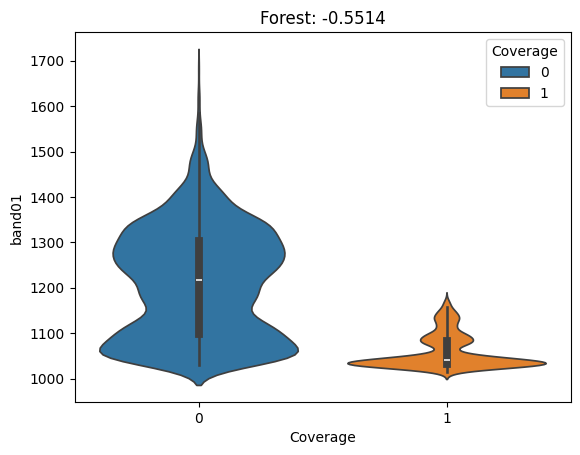

In [48]:
PointBiserial('band01', categ = 'Forest', graf = 'Yes')

Text(0.5, 1.0, 'Eutrophication: 0.1812')

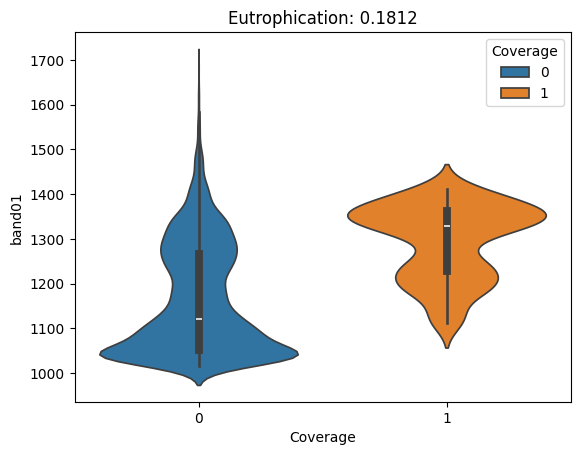

In [49]:
PointBiserial('band01', categ = 'Eutrophication', graf = 'Yes')

In [50]:
PointBiserial('band07', categ = 'Forest', graf = 'No')

Coverage       rpb
0   Forest  0.299522

In [51]:
PointBiserial('band07', categ = 'Crop')

Coverage       rpb
0     Crop  0.164457

## Visualizacion de datos

Hasta ahora hemos podido manipular información raster y vector para construir un único `DataFrame` que contiene nuestras anotaciones e información espectral. Sin embargo, apenas hemos analizado la información. Por eso propongo el siguiente análisis:

* Análisis Univariado: Analicemos la distribución (marginal) de cada banda según los *labels*.
* Análisis Multivariado: Analicemos las distribuciones (conjuntas) de algunos grupos/parejas de bandas según los *labels*

### Univariados

In [53]:
sns.set_theme()
colors = ['#dc1010', '#2b8c26', '#1f78b4', '#ead40c', '#4defef']
sns.set_palette(sns.color_palette(colors))

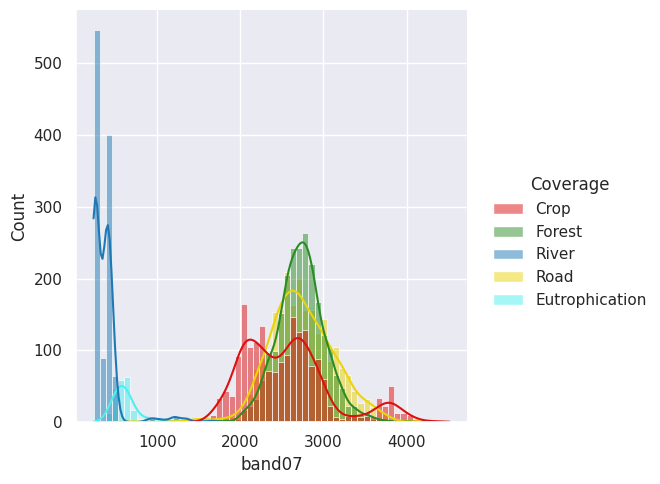

In [54]:
sns.displot(data = roadbands_train, x = 'band07', hue = 'Coverage', kde=True);

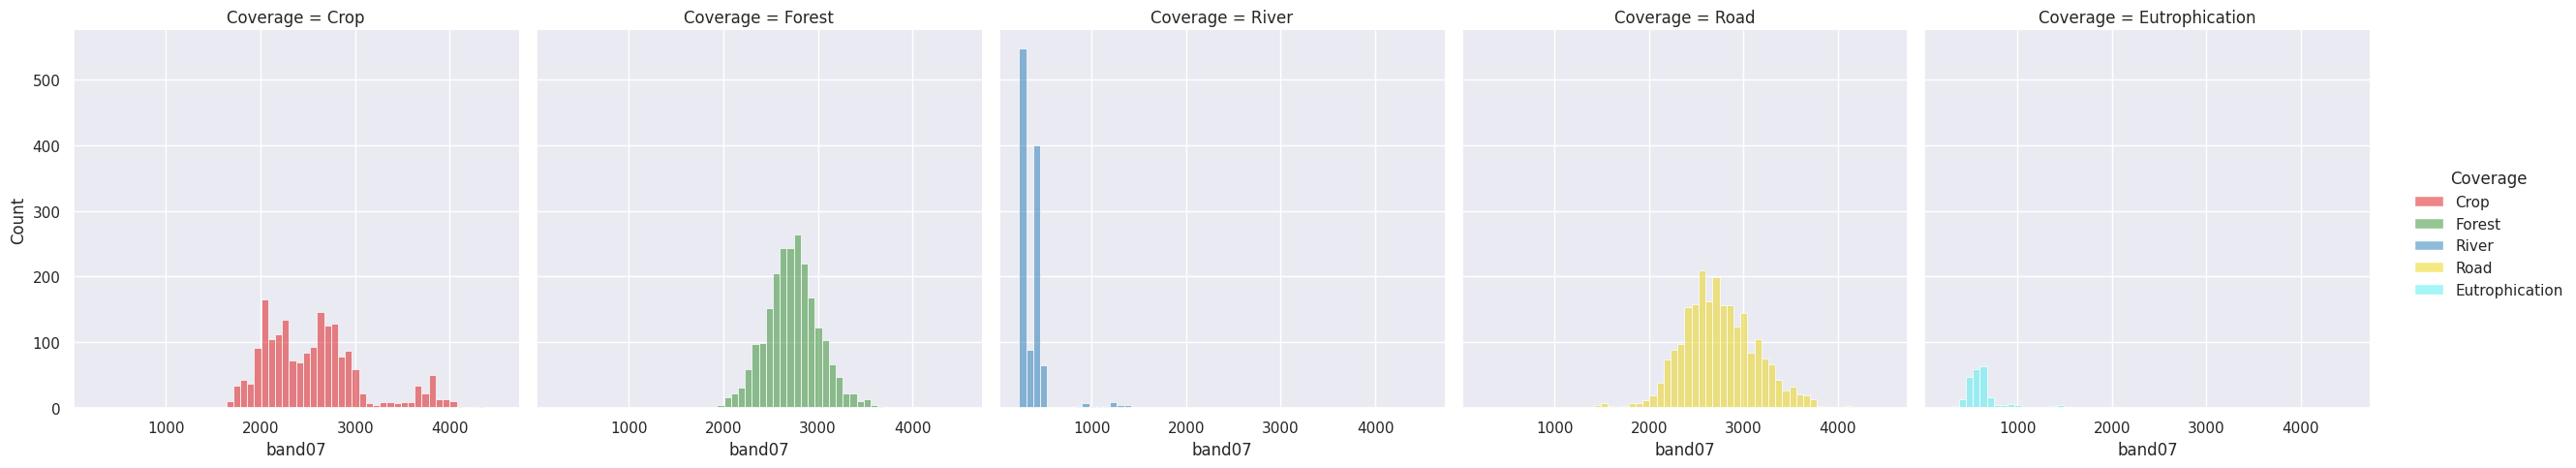

In [55]:
sns.displot(data = roadbands_train, x = 'band07', hue = 'Coverage', col = 'Coverage');

Podemos realizar este análisis de otra manera:

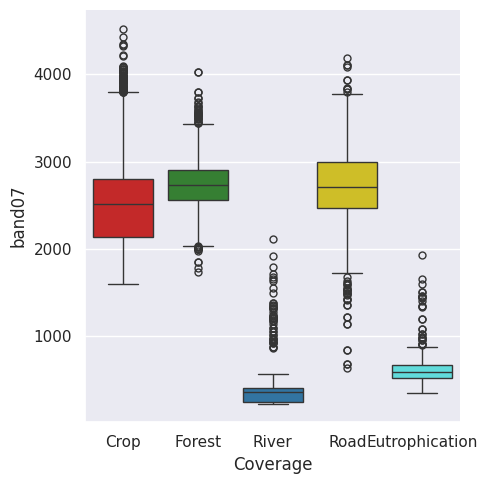

In [56]:
sns.catplot(data=roadbands_train, x='Coverage',y='band07', hue='Coverage', kind='box');

Evidentemente, la información marginal nos puede proporcionar información limitada. Sin embargo, existen estrategias como [*feature engineering*](https://en.wikipedia.org/wiki/Feature_engineering*feature%20engineering) que se encargan realizar procesos que potencian la información de las variables a través de transformaciones y combinación de variables. Por ejemplo, el índice NDVI es el resultado de este proceso. Miremos que nos puede decir este indicador:

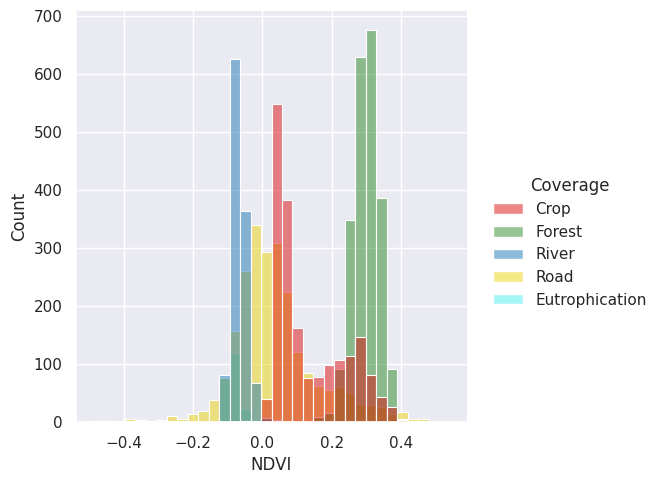

In [57]:
roadbands_train["NDVI"] = (roadbands_train["band05"].astype(float) - roadbands_train["band04"].astype(float))/(roadbands_train["band05"].astype(float) + roadbands_train["band04"].astype(float))
sns.displot(data = roadbands_train, x = "NDVI", hue = "Coverage");

### Multivariados

Ahora extendamos este ejercicio a más variables:

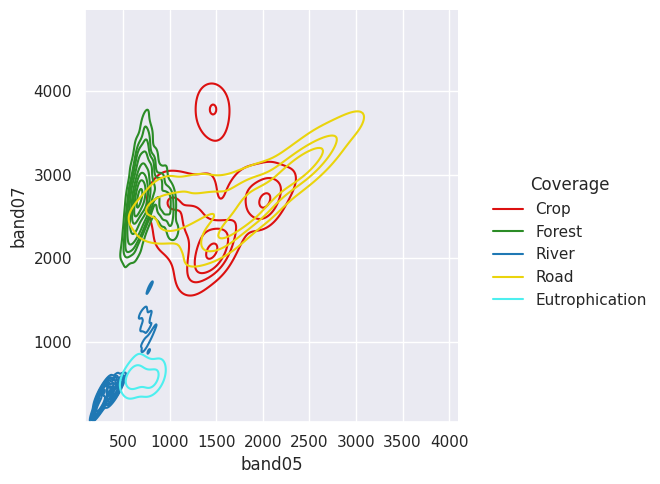

In [58]:
sns.displot(data=roadbands_train, x = "band05", y = "band07", hue='Coverage', kind='kde');

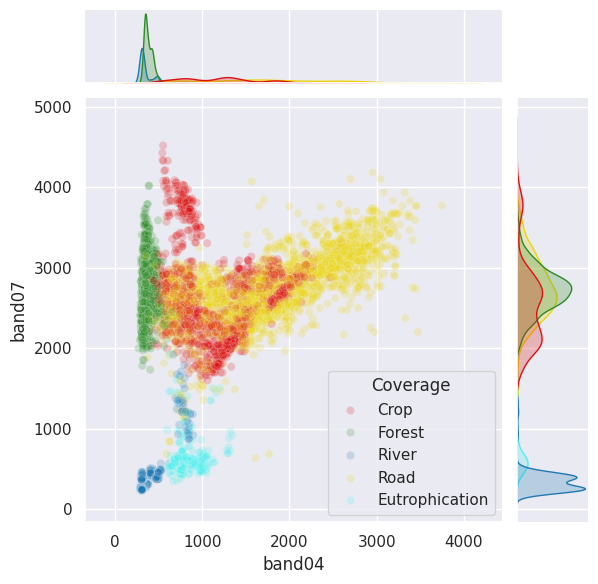

In [59]:
sns.jointplot(data=roadbands_train, x='band04', y='band07', hue='Coverage', alpha=0.2);

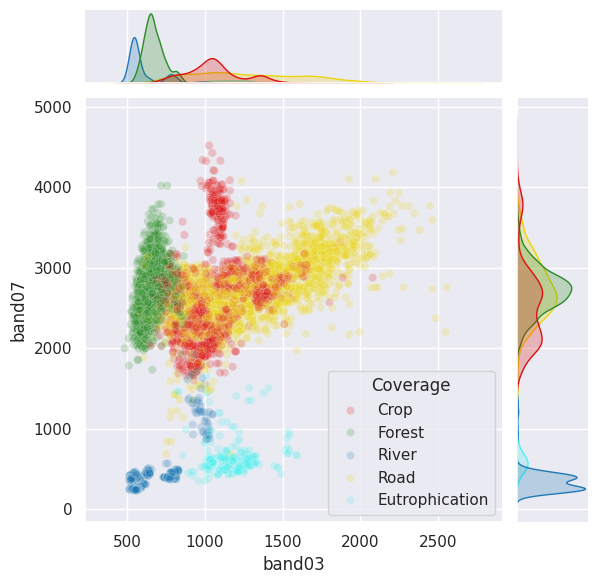

In [60]:
sns.jointplot(data=roadbands_train, x='band03', y='band07', hue='Coverage', alpha=0.2);

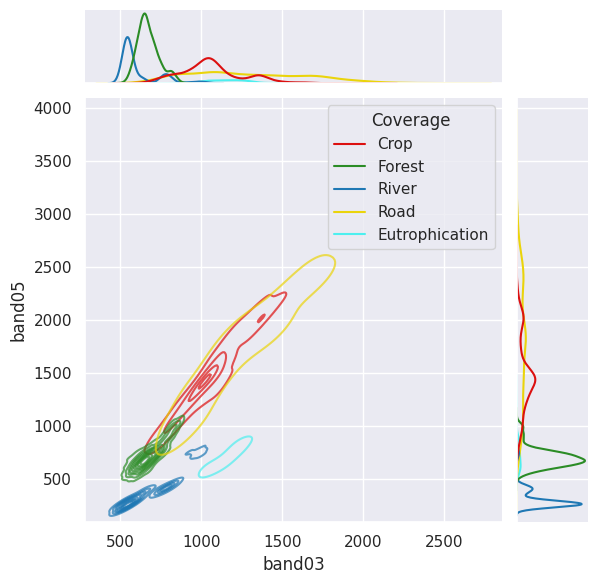

In [61]:
sns.jointplot(data=roadbands_train, x='band03', y='band05', hue='Coverage', kind='kde',alpha=0.7);

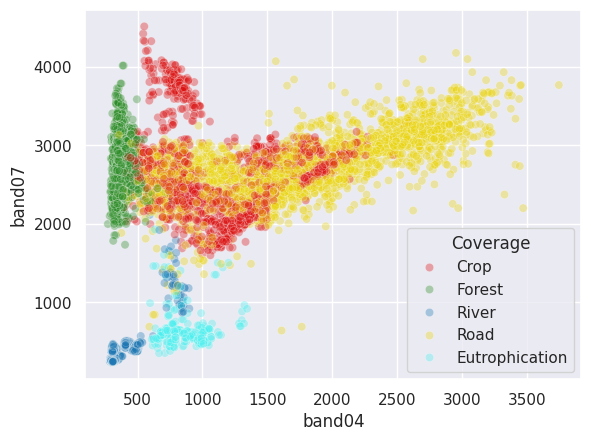

In [62]:
sns.scatterplot(x = "band04", y = "band07", data = roadbands_train, hue = "Coverage", alpha = 0.35);

Integremos toda esta información en un solo gráfico:

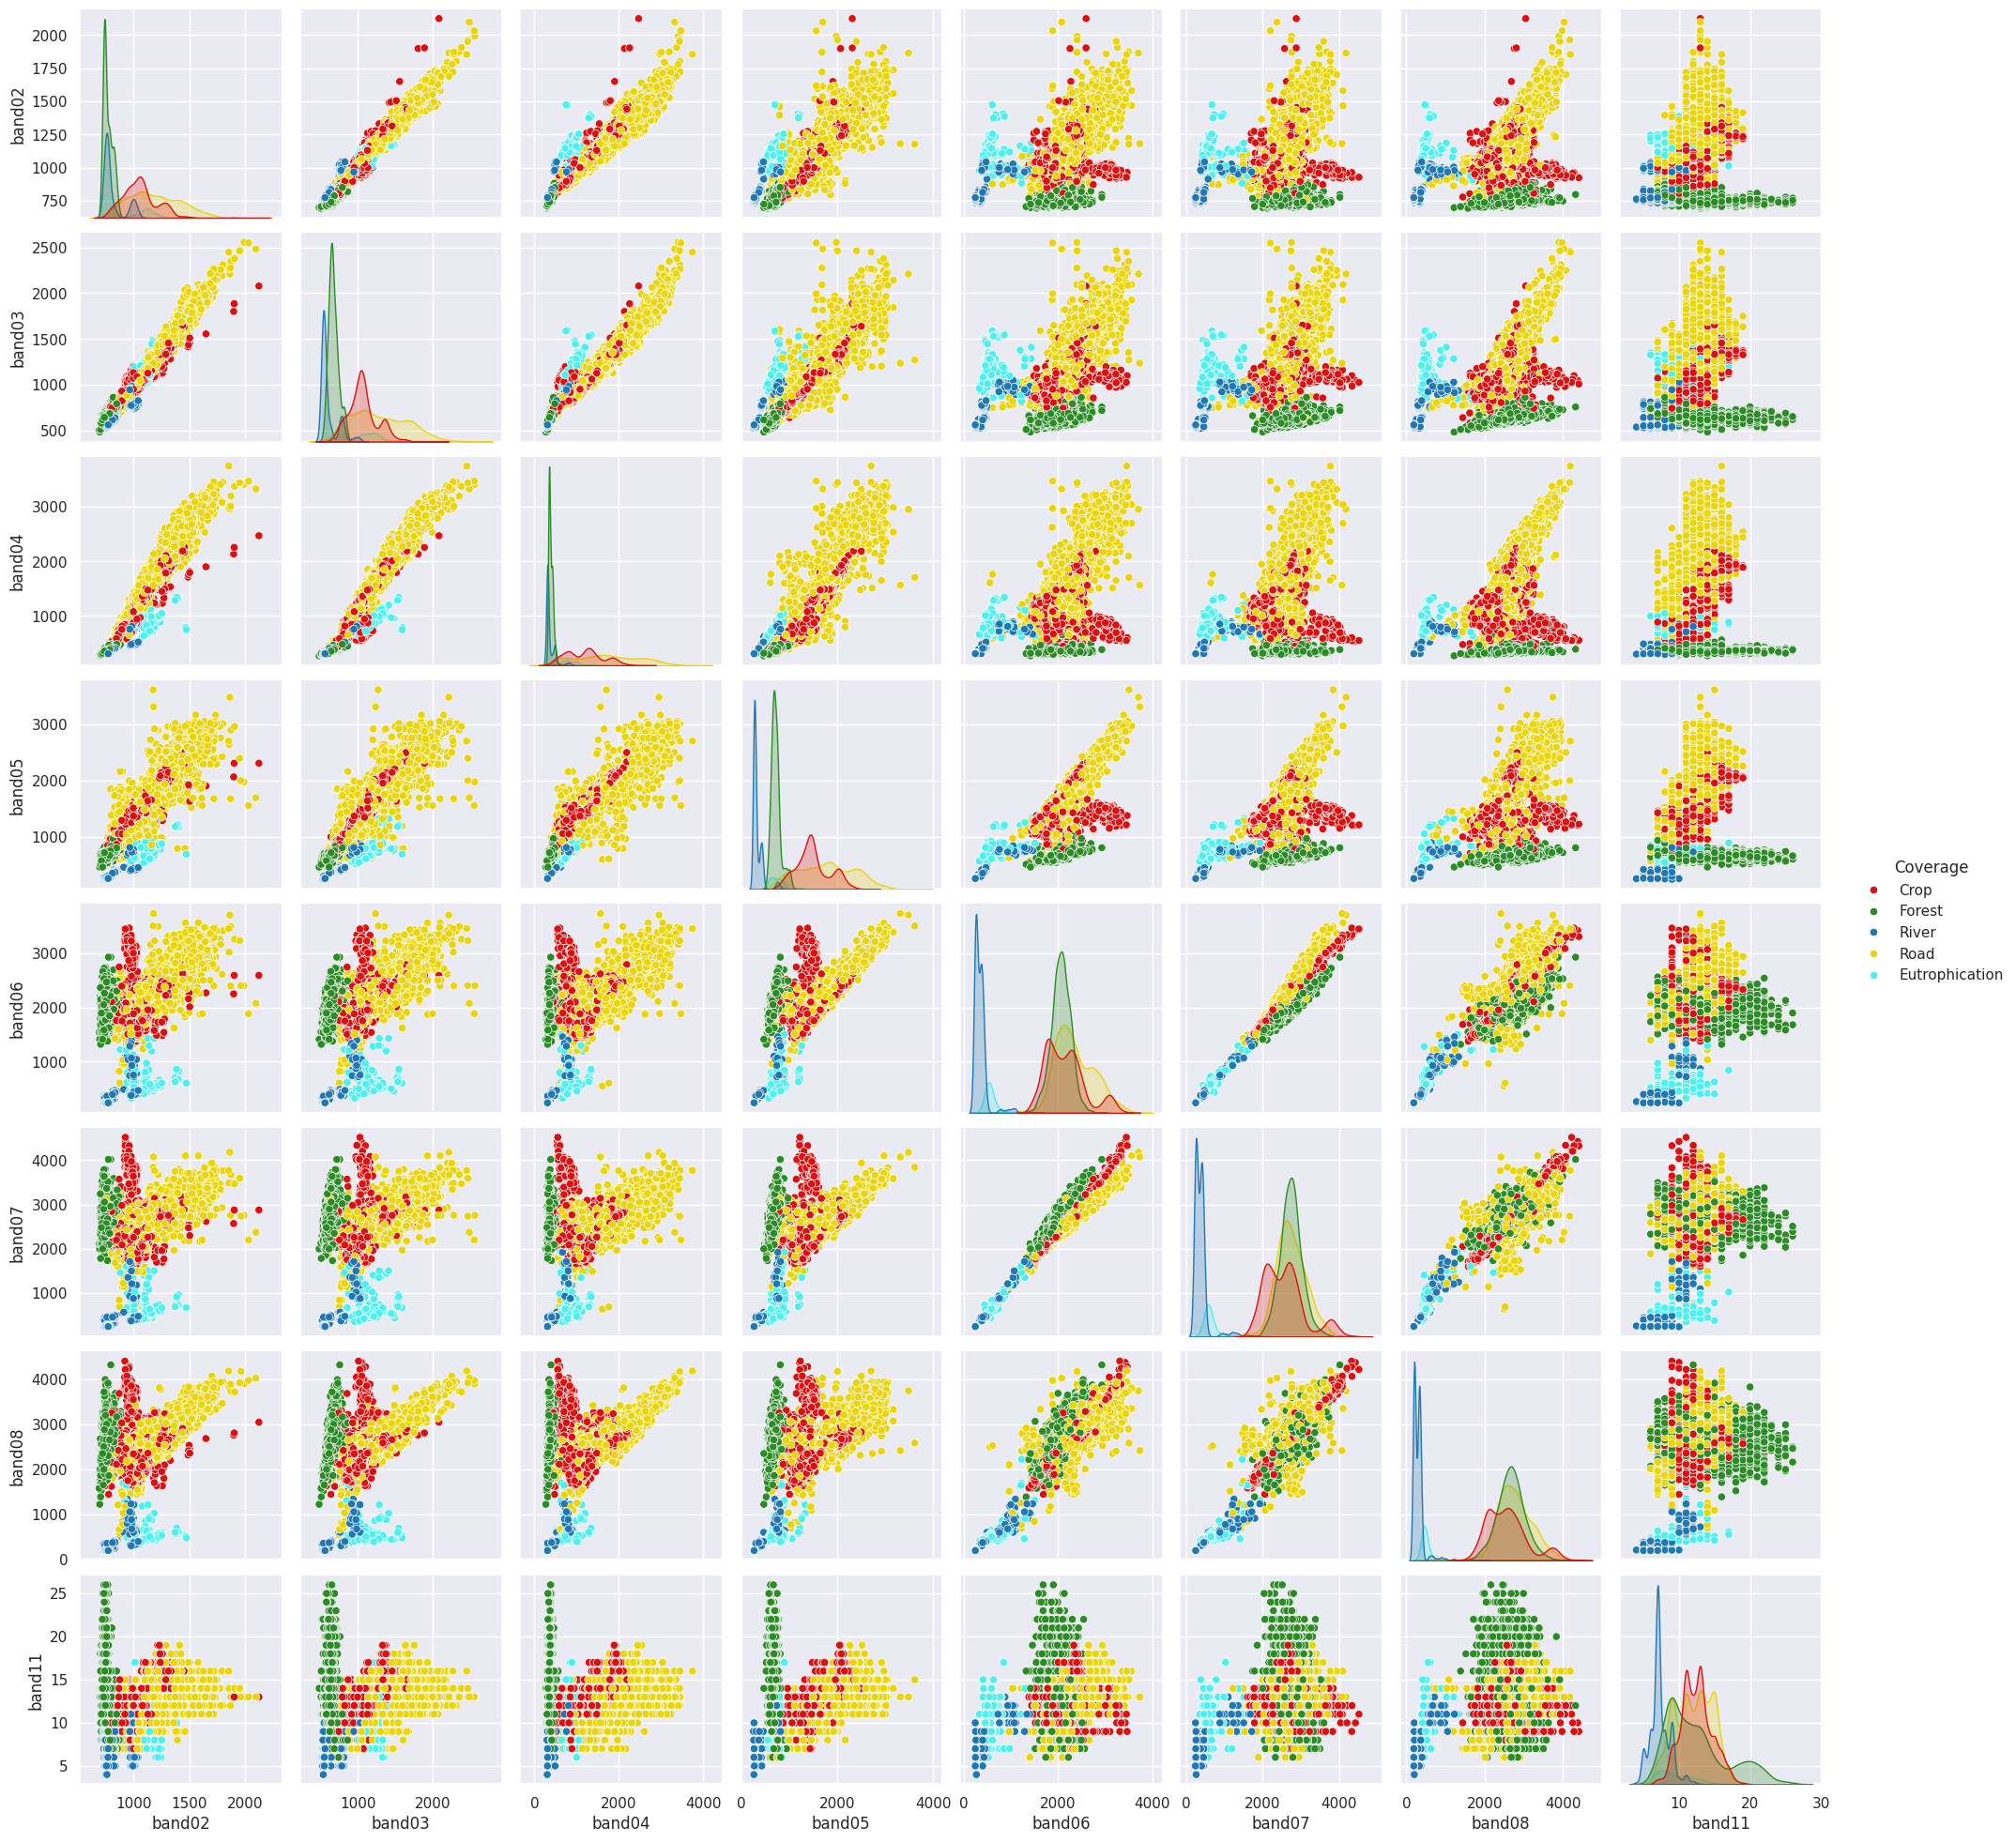

In [63]:
sns.pairplot(roadbands_train, vars = ['band02', 'band03', 'band04', 'band05', 'band06', 'band07', 'band08', 'band11'], hue = 'Coverage');

## Entrenamiento

Entrenar un algoritmo por si solo puede ser retador pero no podremos saber que tan bueno o que tan malo si no evaluamos su capacidad predictiva. Sin embargo, es esencial evaluar su rendimiento relativo con respecto a otro modelos. De manera análoga a la estadística clásica, llamaremos **Ho** a nuestra modelo de línea base, el cual puede ser el modelo más representativo (*statu quo*). En este caso, propongo que utilicemos la regresión logística (*softmax*).

Nuestra hipótesis o modelo(s) de prueba serán llamados **H1**, los cuales pueden ser cualquier modelo diferente a **Ho**.

In [64]:
y_train = roadbands_train['Coverage']
X_train = roadbands_train.drop(columns=['Coverage', 'NDVI'])

y_test = roadbands_test['Coverage']
X_test = roadbands_test.drop(columns=['Coverage'])

In [65]:
X_train.corr()

band01    band02    band03    band04    band05    band06    band07  \
band01  1.000000  0.882709  0.828711  0.800648  0.778908  0.305048  0.162076   
band02  0.882709  1.000000  0.978570  0.961308  0.886207  0.438651  0.284848   
band03  0.828711  0.978570  1.000000  0.966935  0.919912  0.555654  0.410050   
band04  0.800648  0.961308  0.966935  1.000000  0.935640  0.529892  0.378559   
band05  0.778908  0.886207  0.919912  0.935640  1.000000  0.718391  0.582526   
band06  0.305048  0.438651  0.555654  0.529892  0.718391  1.000000  0.980232   
band07  0.162076  0.284848  0.410050  0.378559  0.582526  0.980232  1.000000   
band08  0.186023  0.329712  0.455563  0.425100  0.599055  0.961158  0.971413   
band09  0.138958  0.249055  0.371132  0.343298  0.558263  0.968103  0.993043   
band10  0.213506  0.318461  0.438335  0.413422  0.616500  0.942147  0.949014   
band11  0.240317  0.271129  0.321283  0.347268  0.423615  0.488952  0.478211   
band12  0.728280  0.790996  0.808004  0.860924  0.941240  0.694069  0.578040   
band13  0.784388  0.819173  0.810604  0.872249  0.915627  0.572400  0.443269   

          band08    band09    band10    band11    band12    band13  
band01  0.186023  0.138958  0.213506  0.240317  0.728280  0.784388  
band02  0.329712  0.249055  0.318461  0.271129  0.790996  0.819173  
band03  0.455563  0.371132  0.438335  0.321283  0.808004  0.810604  
band04  0.425100  0.343298  0.413422  0.347268  0.860924  0.872249  
band05  0.599055  0.558263  0.616500  0.423615  0.941240  0.915627  
band06  0.961158  0.968103  0.942147  0.488952  0.694069  0.572400  
band07  0.971413  0.993043  0.949014  0.478211  0.578040  0.443269  
band08  1.000000  0.968756  0.930725  0.483655  0.603648  0.472752  
band09  0.968756  1.000000  0.958693  0.477938  0.579706  0.439871  
band10  0.930725  0.958693  1.000000  0.537483  0.642694  0.500999  
band11  0.483655  0.477938  0.537483  1.000000  0.485788  0.431299  
band12  0.603648  0.579706  0.642694  0.485788  1.000000  0.973737  
band13  0.472752  0.439871  0.500999  0.431299  0.973737  1.000000

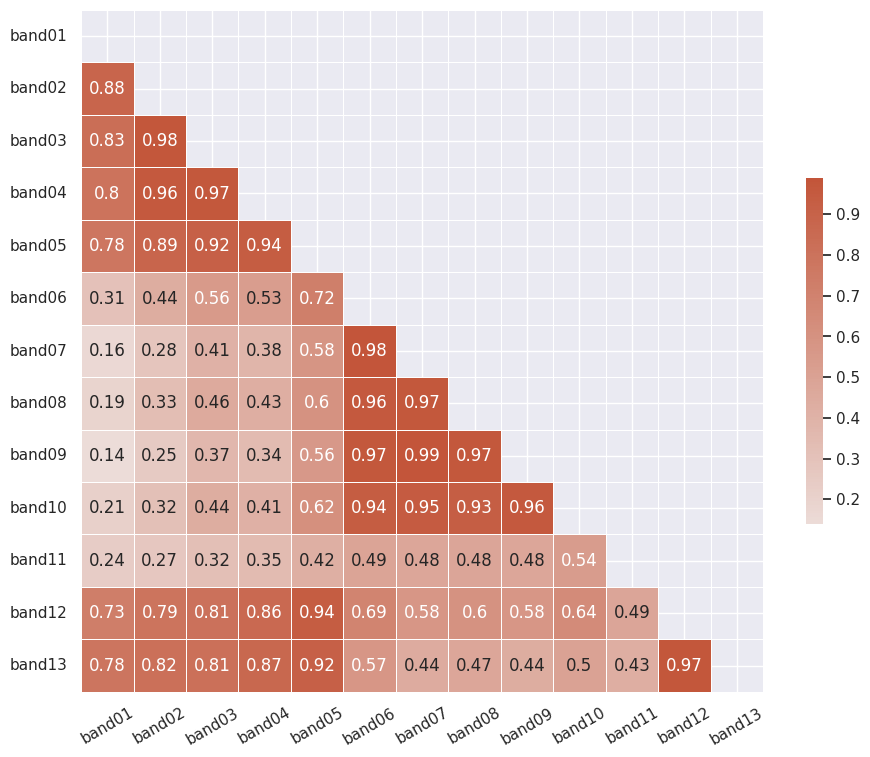

In [66]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(X_train.corr(), dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
g = sns.heatmap(X_train.corr(), mask=mask, cmap=cmap, vmax=.99, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
g.set_xticklabels(
    labels=bandas, rotation=30);

Vemos que existe una alta colinearidad entre variables, lo que puede perjudicar la interpretación y la veracidad de los coeficientes de la regresión logística. Para esto podemos usar **PCA** y/o algoritmos de selección de variables como *Best Subset Selection*.

### Ho: Softmax

In [67]:
softmax_reg = LogisticRegression(C=20, random_state=123)
softmax_reg.fit(X_train, y_train)

softmax_reg

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=20, random_state=123)

In [68]:
y_probas_softmax_reg_clf = softmax_reg.predict(X_train)
y_probas_softmax_reg_clf

array(['Crop', 'Forest', 'Forest', ..., 'Crop', 'River', 'Road'],
      dtype=object)

<Axes: >

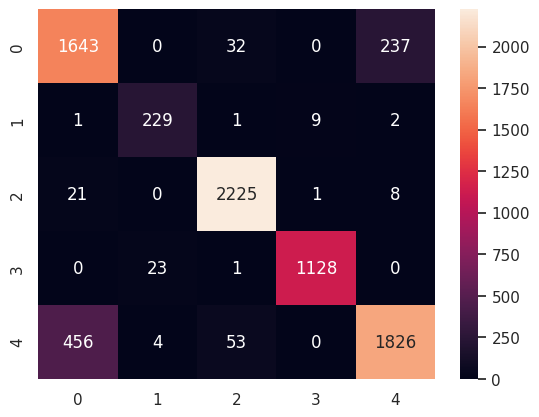

In [69]:
conf_mat_softmax_train = confusion_matrix(y_train, y_probas_softmax_reg_clf)
sns.heatmap(conf_mat_softmax_train, annot=True, fmt=".0f")

Ahora evaluemos el rendimiento de este modelo en el *hold-out set*:

In [70]:
y_softmax_pred_test = softmax_reg.predict(X_test)
y_softmax_pred_test

array(['Eutrophication', 'Forest', 'River', ..., 'Forest', 'Road', 'Crop'],
      dtype=object)

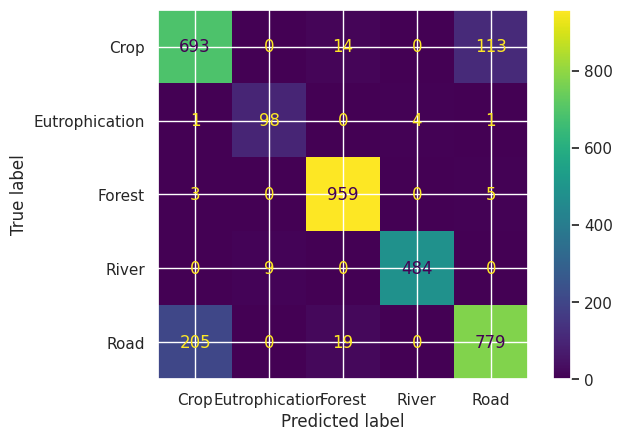

In [71]:
ConfusionMatrixDisplay.from_predictions(y_test, y_softmax_pred_test)
plt.show()

La idea es entrenar modelos **H1** que tengan un rendimiento mucho mejor que nuestro **Ho**.

### AdaBoost

In [72]:
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=10, max_features=3),
    n_estimators=500,
    learning_rate=.5,
    random_state=123
)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=10,
                                                    max_features=3),
                   learning_rate=0.5, n_estimators=500, random_state=123)

In [73]:
y_probas_ada_clf = ada_clf.predict(X_train)
y_probas_ada_clf

array(['Crop', 'Forest', 'Forest', ..., 'Crop', 'River', 'Road'],
      dtype=object)

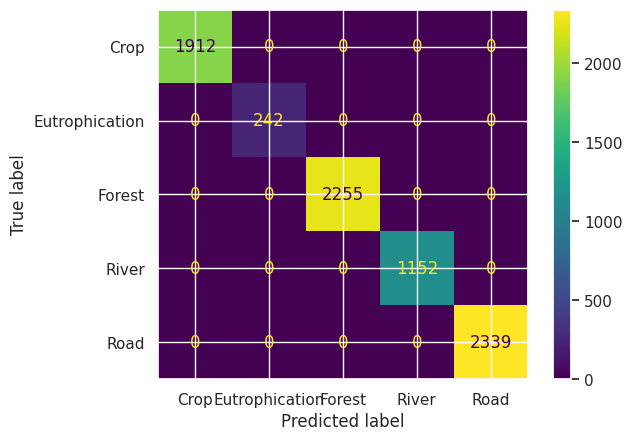

In [74]:
ConfusionMatrixDisplay.from_predictions(y_train, y_probas_ada_clf)
plt.show()

In [75]:
y_ada_clf_pred_test = ada_clf.predict(X_test)
y_ada_clf_pred_test

array(['Eutrophication', 'Forest', 'River', ..., 'Forest', 'Road', 'Crop'],
      dtype=object)

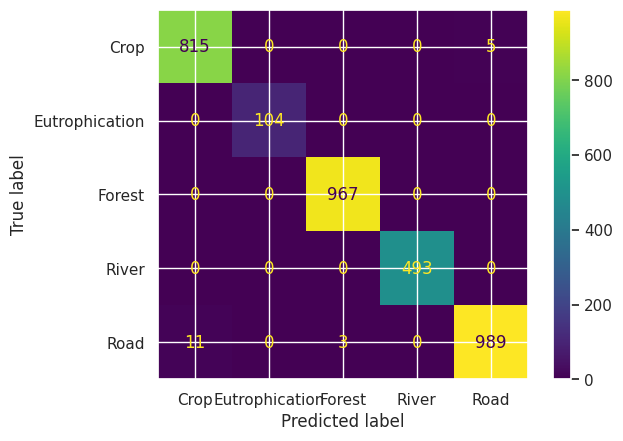

In [76]:
ConfusionMatrixDisplay.from_predictions(y_test, y_ada_clf_pred_test)
plt.show()

### Random Forest

In [77]:
rforest_clf = RandomForestClassifier(random_state=123)
rforest_clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 123,
 'verbose': 0,
 'warm_start': False}

In [78]:
rforest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=123)

In [79]:
y_probas_cforest_clf = cross_val_predict(rforest_clf, X_train, y_train, cv = 5)
y_probas_cforest_clf

array(['Crop', 'Forest', 'Forest', ..., 'Road', 'River', 'Road'],
      dtype=object)

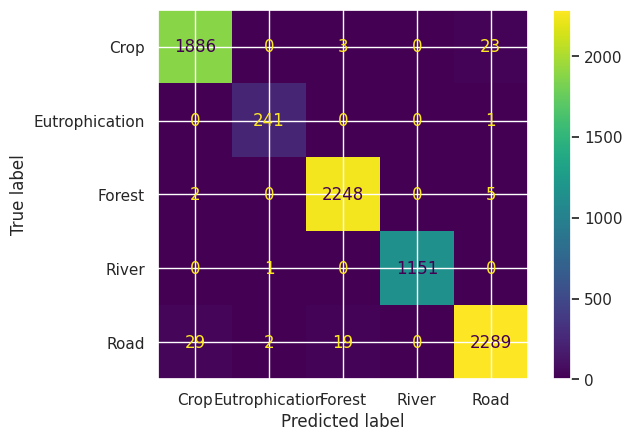

In [80]:
ConfusionMatrixDisplay.from_predictions(y_train, y_probas_cforest_clf)
plt.show()

In [81]:
y_pred_test = rforest_clf.predict(X_test)
y_pred_test

array(['Eutrophication', 'Forest', 'River', ..., 'Forest', 'Road', 'Crop'],
      dtype=object)

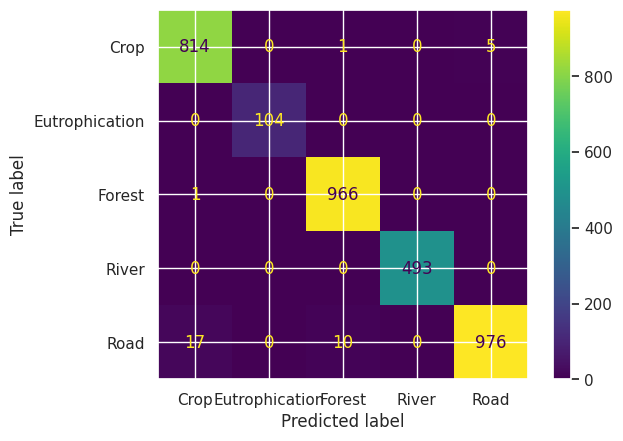

In [82]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
plt.show()

¿Podemos mejorar? Sí, mucho. Es más, el entrenamiento propuesto fue muy sencillo. No realizamos una adecuada calibración de parámetros o exploración exhaustiva de estos.

In [83]:
calibrated_rforest_clf = CalibratedClassifierCV(
    estimator=RandomForestClassifier(random_state=123)
)

In [84]:
rforest_clf_param_grid = [
    {'estimator__max_depth': [1, 5, 10, 15, 25],
     'estimator__n_estimators': [10, 50, 100, 500, 800, 1000]}
]

In [85]:
rforest_clf_param_grid_search = GridSearchCV(calibrated_rforest_clf,
                                             rforest_clf_param_grid,
                                             cv = 10,
                                             scoring='accuracy',
                                             n_jobs=-2,
                                             return_train_score=True)

rforest_clf_param_grid_search

GridSearchCV(cv=10,
             estimator=CalibratedClassifierCV(estimator=RandomForestClassifier(random_state=123)),
             n_jobs=-2,
             param_grid=[{'estimator__max_depth': [1, 5, 10, 15, 25],
                          'estimator__n_estimators': [10, 50, 100, 500, 800,
                                                      1000]}],
             return_train_score=True, scoring='accuracy')

In [ ]:
rforest_clf_param_grid_search.fit(X_train, y_train)

In [ ]:
rforest_clf_param_grid_search.best_estimator_

CalibratedClassifierCV(estimator=RandomForestClassifier(max_depth=25,
                                                        n_estimators=500,
                                                        random_state=123))

In [ ]:
y_probas_calibrated_rforest_clf = rforest_clf_param_grid_search.predict(X_train)
y_probas_calibrated_rforest_clf

array(['Crop', 'Forest', 'Forest', ..., 'Crop', 'River', 'Road'],
      dtype=object)

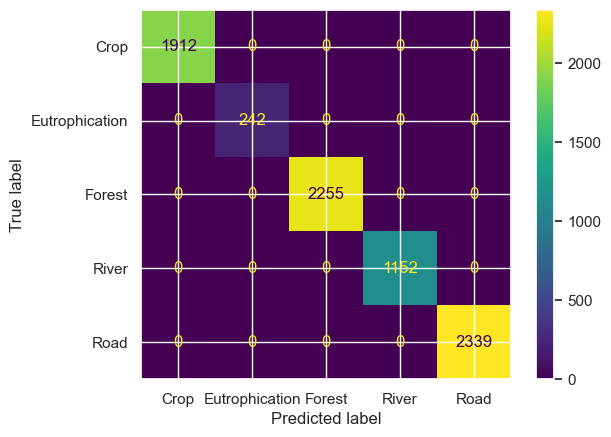

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train, y_probas_calibrated_rforest_clf)
plt.show()

In [ ]:
y_rforest_clf_param_grid_search_pred_test = rforest_clf_param_grid_search.predict(X_test)
y_rforest_clf_param_grid_search_pred_test

array(['Eutrophication', 'Forest', 'River', ..., 'Forest', 'Road', 'Crop'],
      dtype=object)

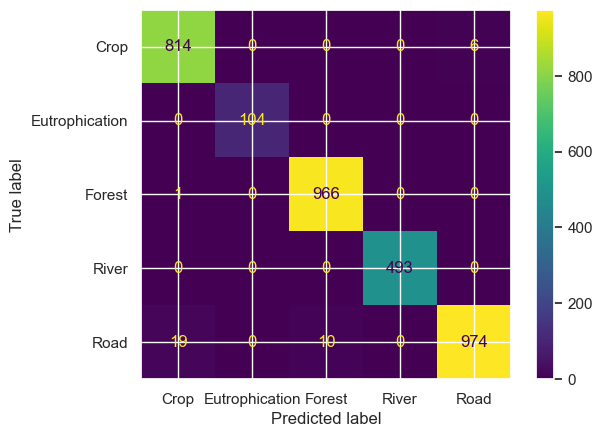

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_rforest_clf_param_grid_search_pred_test)
plt.show()

## Comentarios finales

AdaBoost fue nuestro mejor modelo, incluso sin un entrenamiento adecuado (*fine-tuning*). Realmente no tenemos un razonamiento sólido que justifique los valores de los hiperparámetros. Esto quiere decir que no podemos realizar una selección objetiva de modelos, pero tranquilos, eso lo exploraremos más adelante. Por ahora es suficiente con saber todo lo que puede implicar entrenar un modelo y cómo podemos evaluar su entrenamiento y rendimiento.

## Extension a todo el raster

Recordemos que `zona_estudio` es un tensor o array multidimensional de 13 bandas y ...

In [ ]:
zona_estudio.shape

Sin embargo, nuestro clasificador `rforest_clf` consume datos *bidimensionales* de 13 variables.

In [ ]:
X_test.shape

Entonces, debemos transformar la estructura o forma del raster para que sus valores puedan ser utilizados por nuestro clasificador. Esto lo podemos hacer de la siguiente manera:

In [ ]:
banda01_total = zona_estudio.read(1).reshape(-1)
banda02_total = zona_estudio.read(2).reshape(-1)
banda03_total = zona_estudio.read(3).reshape(-1)
banda04_total = zona_estudio.read(4).reshape(-1)
banda05_total = zona_estudio.read(5).reshape(-1)
banda06_total = zona_estudio.read(6).reshape(-1)
banda07_total = zona_estudio.read(7).reshape(-1)
banda08_total = zona_estudio.read(8).reshape(-1)
banda09_total = zona_estudio.read(9).reshape(-1)
banda10_total = zona_estudio.read(10).reshape(-1)
banda11_total = zona_estudio.read(11).reshape(-1)
banda12_total = zona_estudio.read(12).reshape(-1)
banda13_total = zona_estudio.read(13).reshape(-1)

raster_convertido = pd.DataFrame({'band01':banda01_total,
                                  'band02':banda02_total,
                                  'band03':banda03_total,
                                  'band04':banda04_total,
                                  'band05':banda05_total,
                                  'band06':banda06_total,
                                  'band07':banda07_total,
                                  'band08':banda08_total,
                                  'band09':banda09_total,
                                  'band10':banda10_total,
                                  'band11':banda11_total,
                                  'band12':banda12_total,
                                  'band13':banda13_total})

raster_convertido.head()

Listo, analicemos que tan grande es el raster en esta nueva estructura:

In [ ]:
raster_convertido.shape

Como era de esperar, tiene una cantidad significativa de filas, casi 9 millones de filas. Esto, sin duda, sera una tarea exigente para el clasificado y recurso computacional.

Procedamos sin miedo ...

In [ ]:
rforest_clf_pred_on_raster = rforest_clf.predict(raster_convertido)

In [ ]:
rforest_clf_pred_on_raster

In [ ]:
rforest_clf_pred_on_raster.shape

In [ ]:
np.unique(rforest_clf_pred_on_raster)

In [ ]:
rforest_clf_pred_on_raster = rforest_clf_pred_on_raster.reshape(zona_estudio.read(13).shape[0], zona_estudio.read(13).shape[1])
rforest_clf_pred_on_raster

Tristemente, `rasterio` no grafica arreglos o rasters categoricos, estos deben ser siempre de naturaleza numerica. Entonces, debemos asignar valores:

In [ ]:
raster_pred = rforest_clf_pred_on_raster

raster_pred[raster_pred == 'Crop'] = 1
raster_pred[raster_pred == 'Eutrophication'] = 2
raster_pred[raster_pred == 'Forest'] = 3
raster_pred[raster_pred == 'River'] = 4
raster_pred[raster_pred == 'Road'] = 5

In [ ]:
raster_pred

In [ ]:
raster_pred.shape

In [ ]:
zona_estudio.meta

In [ ]:
transform = Affine(10.0, 0.0, 500570.0, 0.0, -10.0, 8999340.0)
metadata = {
    'driver': 'GTiff',
    'height': raster_pred.shape[0],
    'width': raster_pred.shape[1],
    'count': 1,
    'dtype': 'uint16',
    'crs': CRS.from_epsg(32721),
    'transform': transform
}
# Write to a new raster file
with rasterio.open('output_rforest_clf_pred.tif', 'w', **metadata) as dst:
    dst.write(raster_pred, 1)